In [1]:
#%pip install yfinance numpy statsmodels pandas matplotlib arch openpyxl


Things to do:L


Fit squared D for mVT dist
[@d]



# Introduction
In this paper we will be pricing index basket options, using a combination of time-series forecasts and copula based simulation methods. Specifically, we will be pricing basket options on the DAX, AEX, FTSE 100 Nikkei 225, S&P 500, S&P/TSX indices, with a payoff function $\max{(\text{average return of indices}-k, 0)}$, for various strikes $k$, with a time to maturity of one month.

To do this, we will first fit several GARCH based volatility forecasts to each index, assuming normal, Student's-t, and skewed Student's-t residuals. Then, we will fit a multivariate-t distribution to our data. Goodness of fit tests will be conducted for each model. For each assumed residual distribution, we will use Monte Carlo methods to forecast the payoff of our basket option. We will conclude by simulating the performance of the covered call strategy, and backtesting our results. 


### Background Concepts

We assume that the reader has a basic understanding of time-series models, model fitting, and options[1].
First, let us define our time-series models.

##### ARCH Model
Let us do a brief overview of the Autoregressive Conditional Heteroskedasticity (ARCH) model.

Let $\{y_t\}$  be a time-series. Let $\{\epsilon_t\}$ denote the error terms (known as residuals, with respect to a mean process). We will assume for each time-series that the mean process is constant. We assume that $\epsilon _t = \sigma_t z_t$, where $\sigma_t$ repsents the time-dependent volatility/standard deviation, and $z_t$ is a white noise process (a stochastic process with mean 0, constant volatility, and no autocorrelation). We will assume that our white noise processes have a constantly volatility of 1.

We forecast conditional volatility as: $$\sigma^2_t = \alpha_0 + \sum_{i=1}^{q} {\alpha_i \epsilon^2_{t-i}}$$

for some $\alpha_0 > 0, \alpha_i \geq 0$ where q represents the order of the ARCH process (i.e. the number of previous residuals to consider).

The main feature of this model is that it is able to capture volatility clustering in the data, by considering past "shocks" or errors. 

##### GARCH Model
The above can be generalized, by also including an moving average of the previous volatilities. This results in a Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model.

We forecast conditional volatility as: $$\sigma^2_t = \omega + \sum_{i=1}^{q} {\alpha_i \epsilon^2_{t-i}}+\sum_{i=1}^{p} {\beta_i \sigma^2_{t-i}} $$ for some $\omega > 0, \alpha_i \geq 0, \beta_i \geq 0$ where q represents the order of the ARCH process, and p repsents the order of the GARCH process (i.e. the number of previous volatilities to consider).

This model has the added capability of capturing the persistance of previous volatility.

For an intuitive understanding of the parameters, consider the yield of US Government bonds. Note that in the bond market, there are few market moving events, apart from the occasional interest rate change. The response to each interest rate change is generally small, as the effect has been priced in, yielding low values of $\alpha_i$. However, once volatility increases, it tends to be persistant, yielding high values of $\beta_i$. For empirical justification of this situation, see the fitted parameters [here](#Fit-GARCH-Models).




##### Noise Processes
We will assume that our noise process follows one of the following:
1. A Standard Normal distribution $N(0,1)$
2. A Standard Student's-t distribution with a fitted degrees of freedom $t_\nu (0,1)$
3. A Skewed Student's-t distribution with fitted degrees of freedom and skew parameter

We assume that the reader is familiar with the first two distributions, and thus we will only highlight the latter distribution.
##### Skewed Student's-t distribution

We use the density function given by Hansen in [[1]](#references), and refer the reader there for a more indepth analysis:


$$g(z|\eta, \lambda) =
\begin{cases}
    bc \left(1 + \frac{1}{\eta - 2} \right) \left( \frac{bz + a}{1 + \lambda} \right)^{-(\eta + 1)/2} & \text{if } z < -a/b, \\
    bc \left(1 + \frac{1}{\eta - 2} \right) \left( \frac{bz + a}{1 + \lambda} \right)^{-(\eta + 1)/2} & \text{if } z \geq -a/b,
\end{cases}$$

where $2 < \eta < \infty$ and $-1 < \lambda < 1$, and $ a = 4\lambda c \left( \frac{\eta - 2}{\eta - 1} \right)$, $b^2 = 1 + 3A \lambda^2 - a^2$, $c = \frac{\Gamma\left( \frac{\eta + 1}{2} \right)}{\sqrt{\pi (\eta - 2)}} \left( \frac{\eta}{2} \right)$ 


The idea behind this distribution is to generalize the Student's-t distribution, to allow for skewness. Fortunately, the arch library, from [[5]](#references), allows us to easily sample from this skewed Student's-t distribution.


## Preliminary Work

#### Import Libraries

We will use: 
1. The yfinance library from [[2]](#references) to download our data,
2. numpy from [[3]](#references) and pandas from [[4]](#references) for data structures,
3. the arch library from [[5]](#references) for fitting GARCH models, and conducting Goodness of Fit tests
4. the scipy library from [[6]](#references) for fitting multivariate models, conducting simulations, and conducting Goodness of Fit tests
5. the statsmodels library from [[7]](#references) for graphing autocorrelation functions and fitting t-copulas
6. the matplotlib library from [[8]](#references) for data visualization

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from arch.univariate import SkewStudent
from scipy.stats import norm, t, multivariate_t, chi2, f
from scipy.optimize import minimize
from statsmodels.distributions.copula.api import StudentTCopula
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

#### Import Data
This cell imports index data from Yahoo Finance, using the yFinance library, or alternatively, loads previously cached data.

In [3]:
# List of ticker symbols for each index
tickers = ["^GDAXI", "^AEX", "^FTSE", "^N225", "^GSPC", "^GSPTSE", "^TYX"]  # DAX, AEX, FTSE 100, Nikkei 225, S&P 500, S&P/TSX Composite
index_datasets = {}

#Set to True to download data from Yahoo Finance using the yFinance library
#Set to False to use previously cached data
DOWNLOAD_DATA = False


if DOWNLOAD_DATA:
    # Loop over each ticker symbol to fetch the data
    for ticker in tickers:
        # Retrieve the historical data starting from November 20, 1992
        index = yf.Ticker(ticker)
        #Save to dictionary
        index_datasets[ticker] = index.history(start="1992-11-20")   #(start="1992-11-20")

        # Convert the Date column to Datetime
        (index_datasets[ticker]).index = pd.to_datetime((index_datasets[ticker]).index.normalize().tz_localize(None))
        
        index_datasets[ticker] = round(index_datasets[ticker],12)

        #Write data to disk
        index_datasets[ticker].to_excel(".\\Saved Data\\"+ticker+'.xlsx', index=True)
else:
    import os
    # Loop over each ticker symbol
    for ticker in tickers:
        # File path to saved data
        file_path = os.path.join(".\\Saved Data\\"+ticker+'.xlsx')
        
        if os.path.exists(file_path):
            # Load the saved data from Excel
            index_data = pd.read_excel(file_path, index_col=0, parse_dates=True)
            
            # Convert the Date column to Datetime
            index_data.index = pd.to_datetime(index_data.index.normalize().tz_localize(None))

            # Save it to the dictionary
            index_datasets[ticker] = round(index_data,12)
            
            # Optional: Print the first few rows of the data for verification
            print(f"Loaded data for {ticker}:\n", index_data.head())
        else:
            print(f"Excel file for {ticker} not found at {file_path}")


    

Loaded data for ^GDAXI:
                    Open         High          Low        Close  Volume  \
Date                                                                     
1992-11-20  1547.839966  1547.839966  1547.839966  1547.839966       0   
1992-11-23  1523.619995  1523.619995  1523.619995  1523.619995       0   
1992-11-24  1526.680054  1526.680054  1526.680054  1526.680054       0   
1992-11-25  1513.420044  1513.420044  1513.420044  1513.420044       0   
1992-11-26  1523.020020  1523.020020  1523.020020  1523.020020       0   

            Dividends  Stock Splits  
Date                                 
1992-11-20          0             0  
1992-11-23          0             0  
1992-11-24          0             0  
1992-11-25          0             0  
1992-11-26          0             0  
Loaded data for ^AEX:
                   Open        High         Low       Close  Volume  Dividends  \
Date                                                                            
1992-

#### Compute log-returns
We merge all of the data stored in the index_datasets dictionary into one Pandas dataframe. We sample the data on a monthly basis, using a forward fill to account for any missing dates. The forward fill is required to account for different exchanges having different holidays. We then compute the monthly log-returns for each index. We then drop all data apart from the date and monthly log-returns from our dataframe.


In [4]:
# Initialize a DataFrame to store merged data
merged_data = pd.DataFrame()
k=0

# Loop over each ticker symbol to fetch the data
for ticker in tickers:

    index_data = index_datasets[ticker]

    # Extract only the Date and Close columns, reset the index
    close_data = (index_data[['Close']]).copy()

    close_data.rename(columns={'Close': ticker},inplace=True)
    
    # Merge with the previously merged data
    if merged_data.empty:
        merged_data = close_data
    else:
        merged_data = pd.merge(merged_data, close_data, on='Date')

for ticker in tickers:
    #Forward fill missing data
    merged_data[ticker] = merged_data[ticker].ffill()

#Resample at end of each month
merged_data = merged_data.resample("ME").last()

#Compute Log Returns
merged_data[:] = np.log(1+merged_data.pct_change())

#Drop blank entries in first row (if any)
merged_data.dropna(inplace=True)

# Model Fitting

#### Compute Emperical Moments

In [5]:
# Create a dataframe for the first four empirical moments (mean, variance, skewness, kurtosis)
print("Empirical moments for each index's monthly log-returns:\n")
moments_df = pd.DataFrame(columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'], index=tickers)

# Calculate and print empirical moments for each ticker
for ticker in tickers:
    data = merged_data[ticker] 
    moments_df.loc[ticker, 'Mean'] = data.mean()
    moments_df.loc[ticker, 'Variance'] = data.var()
    moments_df.loc[ticker, 'Skewness'] = data.skew()
    moments_df.loc[ticker, 'Kurtosis'] = data.kurtosis()

print(moments_df)   

Empirical moments for each index's monthly log-returns:

             Mean  Variance  Skewness  Kurtosis
^GDAXI   0.006703  0.003432 -0.825112  2.748861
^AEX     0.005083  0.002829 -0.934392  2.595402
^FTSE    0.002842  0.001509  -0.69922  1.200117
^N225    0.002085  0.003134 -0.584054  1.236312
^GSPC     0.00686  0.001819 -0.660288  1.198035
^GSPTSE  0.005302  0.001734  -1.06382  3.594747
^TYX    -0.001292  0.004282 -0.132197   3.96642


## Fit GARCH Models
Here, we first fit a Students-t GARCH model to the log-return data for each index, using the arch library.

To do this, we must first decide what order $(p)$ to use for the GARCH terms $(\sigma^2_t)$, and what order $(q)$ to use for the ARCH Terms $(\epsilon_t)$.

#### Choose (p,q)

We will test different pairs of $(p,q)$, and choose the one with the lowest average Akaike Information Criterion (AIC) across all distributions and indices.

Note: We are actually fitting the GARCH model to 100 times the log-return data, as recommended by the library documentation. This is done to improve numerical stability. 


In [6]:
distributions = ("normal","t","skewt")

combinations = [(i, j) for i in range(1, 5) for j in range(1, 5)]
# i.e. [(1,1),(1,2),...,(1,4),(2,1),(2,2),...,(4,4)]

best_AIC = pd.DataFrame(np.inf,columns=tickers, index = distributions)
best_pair = pd.DataFrame(columns=tickers, index = distributions)

for dist in distributions:
    for (p,q) in combinations:
        for ticker in tickers:
            # as suggested by the documentation, we scale our data to improve numerical stability
            model = arch_model(merged_data[ticker]*100, vol="Garch", p=p, q=q, dist=dist, rescale=False)  
            aic = model.fit(options={'maxiter': 10000, 'ftol': 1e-8},disp="off").aic

            if best_AIC.loc[dist,ticker] > aic:
                best_AIC.loc[dist,ticker] = aic
                best_pair.loc[dist,ticker] = (p,q)

print(best_pair)
print(best_AIC)

        ^GDAXI    ^AEX   ^FTSE   ^N225   ^GSPC ^GSPTSE    ^TYX
normal  (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 4)
t       (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 4)
skewt   (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 4)
             ^GDAXI         ^AEX        ^FTSE        ^N225        ^GSPC  \
normal  2417.248107  2309.760802  2106.195444  2418.142477  2151.525107   
t       2393.247190  2305.327524  2102.164883  2415.919203  2150.672410   
skewt   2380.694814  2291.113156  2086.742044  2404.974011  2128.182584   

            ^GSPTSE         ^TYX  
normal  2142.131049  2449.527001  
t       2125.992288  2424.255206  
skewt   2109.607575  2424.421894  


The above results suggest that GARCH(1,1) models best fit our data, for all distribution/equity index pairs. Also, the skewed Student's-t GARCH(1,1) model has the best fit for all equity indices, as evident by its relatively lower AIC.

Thus, it is best if we set the order of our GARCH and ARCH terms to (1,1), for each index and distribution.


##### Fit GARCH(1,1) models

Next, we will save our normal, Student's-t and skewed Student's-t GARCH(1,1) models, as well as their standarized residuals.

In [7]:
fitted_models = {}
std_residuals = {}

#Fit each GARCH model, store models in fitted_models dictionary and standarized residuals in std_residuals dictionary
for dist in distributions:
    for ticker in tickers:
        # as suggested by the documentation, we scale our data to improve numerical stability
        model = arch_model(merged_data[ticker]*100, vol="Garch", p=1, q=1, dist=dist, rescale=False)  
        fitted_models[(ticker,dist)] = model.fit(options={'maxiter': 1000, 'ftol': 1e-8},disp="off")
        std_residuals[(ticker,dist)] = fitted_models[(ticker,dist)].resid / fitted_models[(ticker,dist)].conditional_volatility

#Creates a dataframe with the fitted parameters from each model, and prints results
print("Fitted parameters for each model:\n")
for dist in distributions:
    df = pd.DataFrame(columns=tickers)
    for ticker in tickers:
        df[ticker] = fitted_models[(ticker,dist)].params
    print("\nModel: "+dist)
    print(round(df,10)) 

Fitted parameters for each model:


Model: normal
            ^GDAXI      ^AEX     ^FTSE      ^N225     ^GSPC   ^GSPTSE  \
mu        0.964131  0.816438  0.469367   0.306787  0.860022  0.841433   
omega     4.484222  3.102596  1.464254  12.153260  1.016158  2.383094   
alpha[1]  0.194967  0.267266  0.172396   0.114575  0.188905  0.349233   
beta[1]   0.684662  0.635418  0.736675   0.496661  0.764669  0.562886   

              ^TYX  
mu       -0.254491  
omega     7.064958  
alpha[1]  0.251305  
beta[1]   0.581627  

Model: t
            ^GDAXI      ^AEX     ^FTSE      ^N225      ^GSPC   ^GSPTSE  \
mu        1.178459  0.906917  0.600515   0.473156   0.964689  0.829408   
omega     3.321433  3.458405  1.653682   2.204455   1.003712  1.461025   
alpha[1]  0.187546  0.251239  0.186750   0.048771   0.193678  0.190251   
beta[1]   0.728081  0.632661  0.713560   0.878969   0.763260  0.736644   
nu        5.906855  9.413508  9.051205  12.443380  12.098541  6.688482   

              ^TYX  
mu 

Recall that we scaled our log-returns by a factor of $100$ before fitting each model. Hence, our mean returns (mu) above are scaled by a factor of $100$, while our baseline variances (omega) are scaled by a factor of $100^2$

We note that, in each model, the Nikkei 225 has a low alpha parameter, suggesting a lack of volatility clustering. Additionally, we note that, when compared to the other indices, the Nikkei 225 log-returns distribution demonstrates thinner tails, as demonstrated by the greater degrees of freedom in both the classical and skewed Student's-t GARCH models.

The other indices are distributed with much fatter tails, with fitted degrees of freedom ranging between 5.67 - 9.18, and 6.54 - 13.95 for the classical and skewed Student's-t GARCH models, respectively.

We observe that each index's returns are negatively skewed, as evident by the lambda parameter in the skewed Student's-t GARCH models.


#### GARCH Goodness of Fit Tests

##### Plot ACF of Standardized Residuals

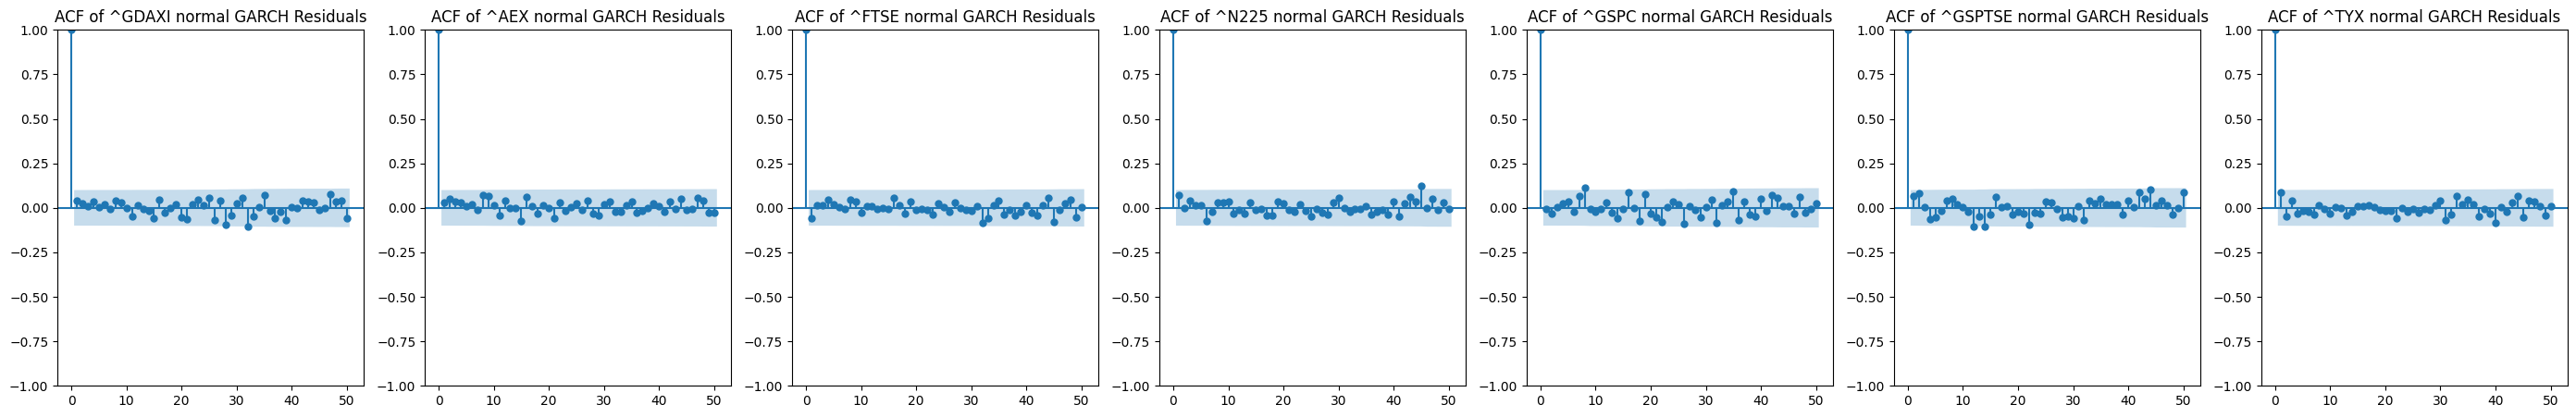

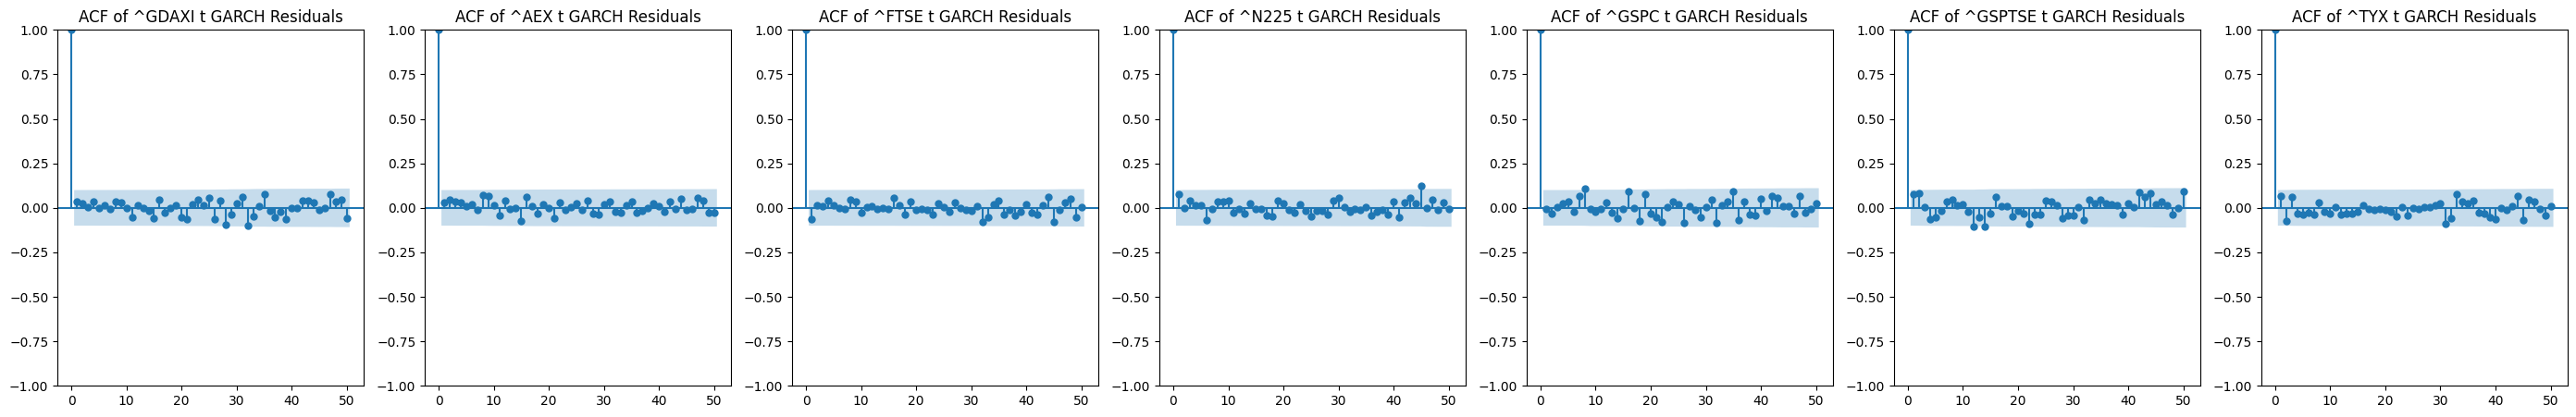

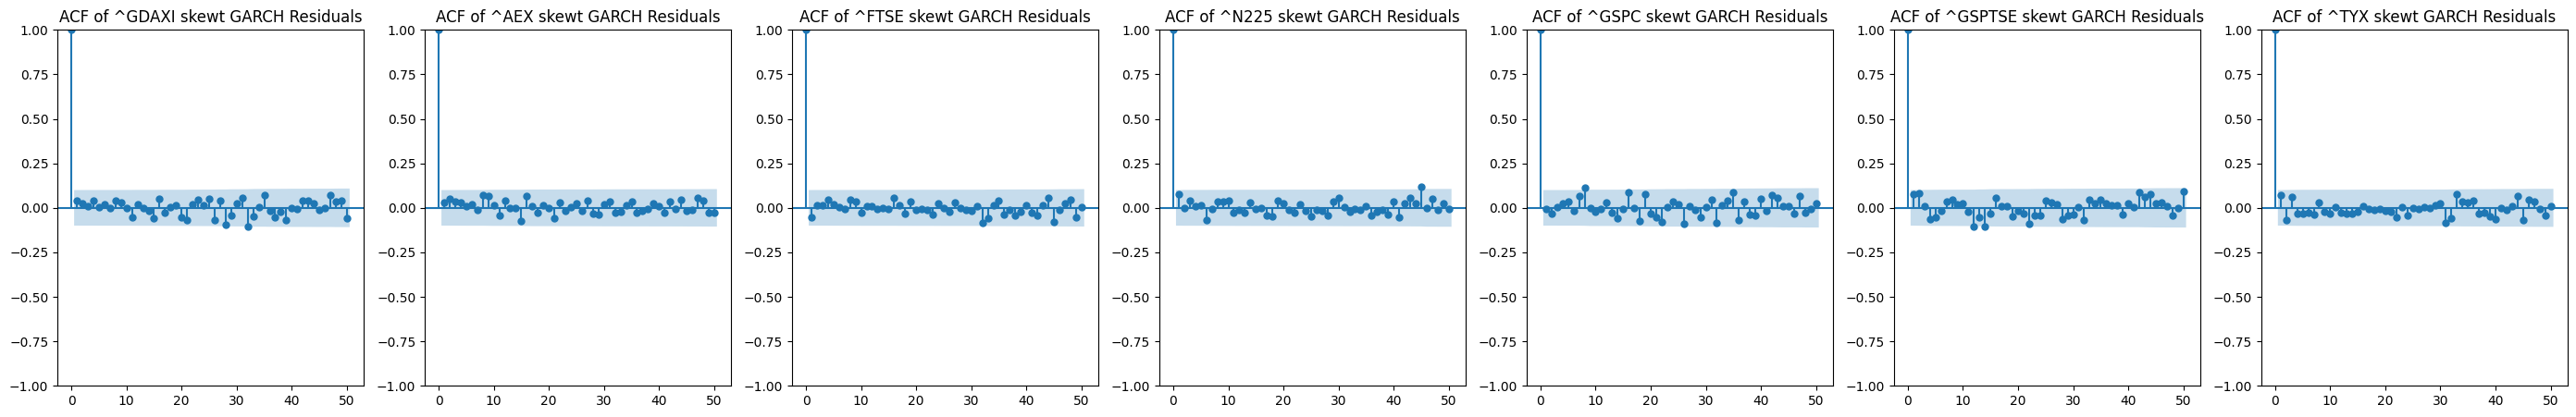

In [8]:
#This plots the ACF of the residuals of each GARCH, and displays them side by side for comparision
for dist in distributions:
    num_tickers = len(tickers)
    fig, axes = plt.subplots(1, num_tickers, figsize=(5 * num_tickers, 5))
    for i in range(num_tickers):
        ticker = tickers[i]
        plot_acf(std_residuals[(ticker,dist)], lags=50, ax=axes[i]) 
        axes[i].set_title('ACF of ' + ticker + " " + dist + ' GARCH Residuals')


The above results suggest that there is little autocorrelation in the stardarized residuals of our fitted GARCH models.

##### Plot ACF of Squared Standardized Residuals

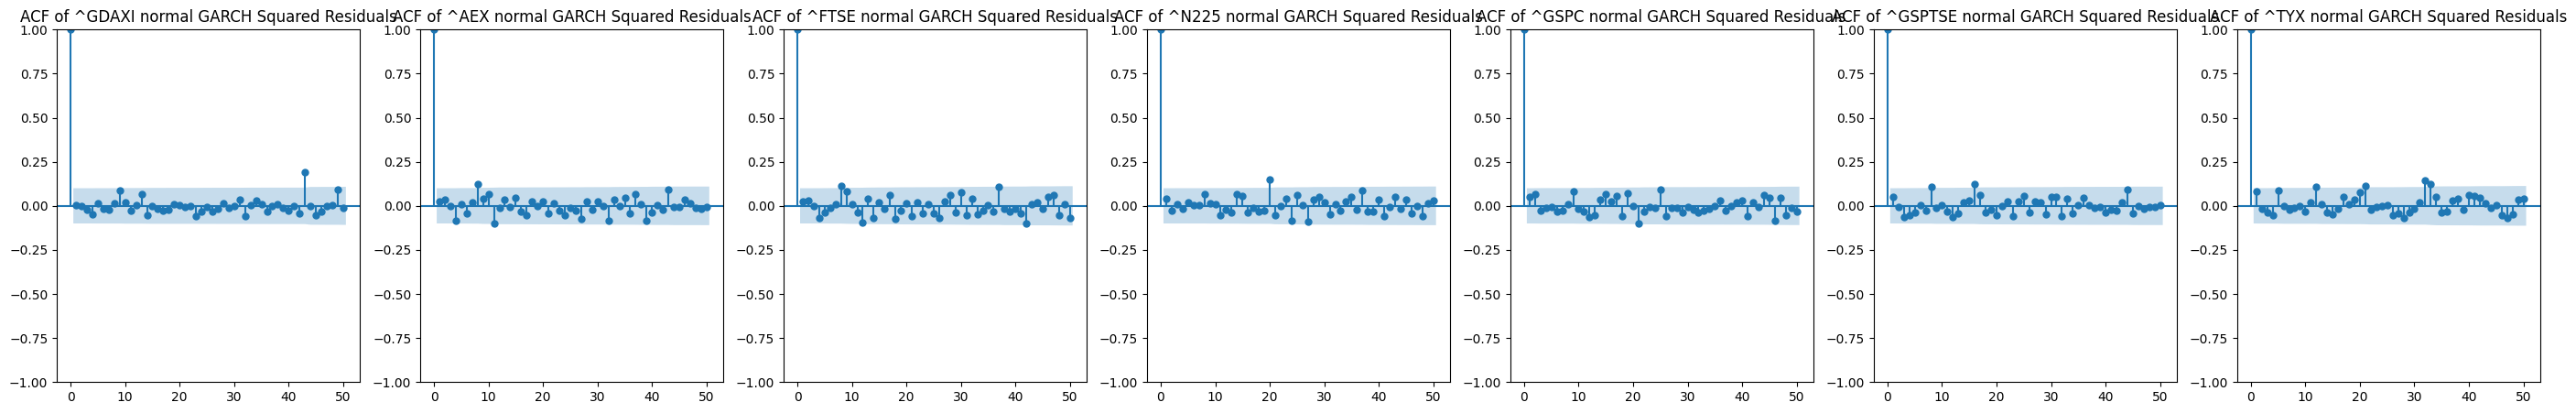

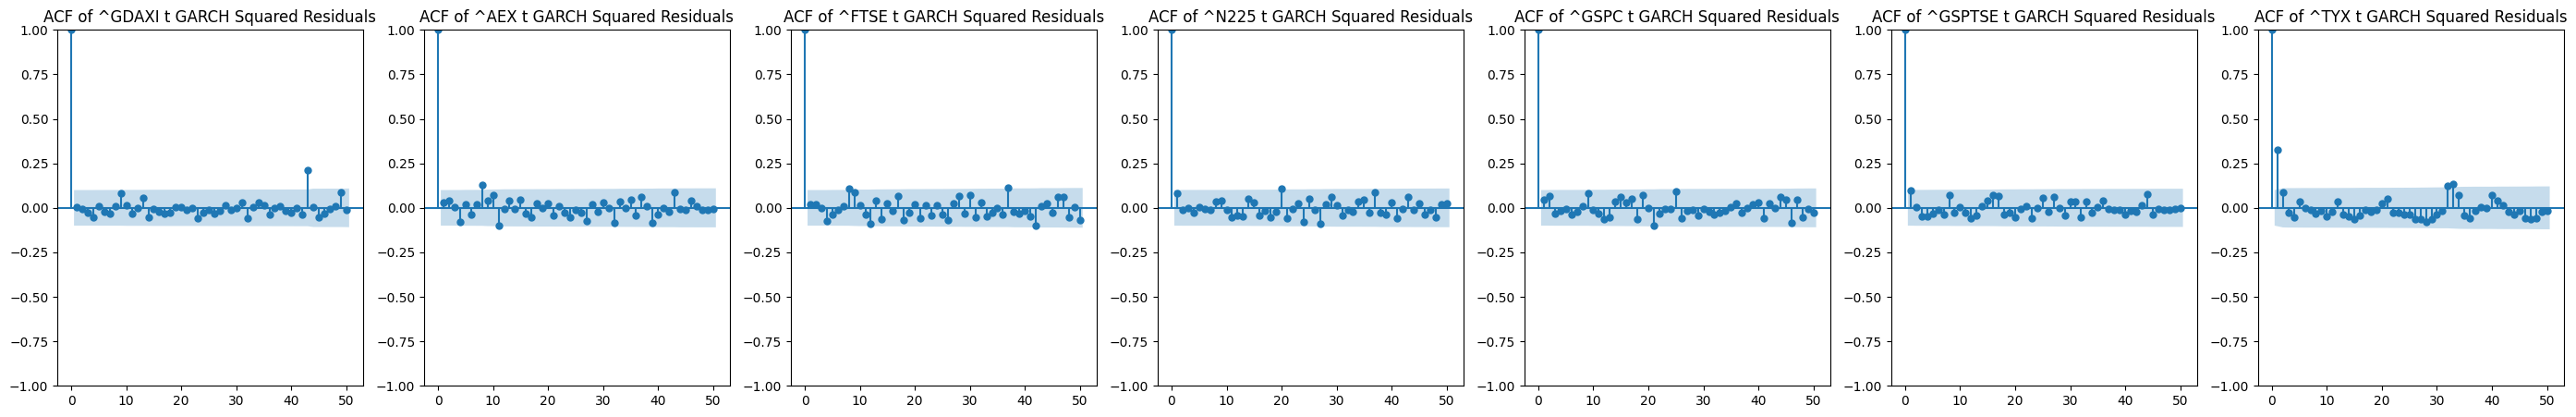

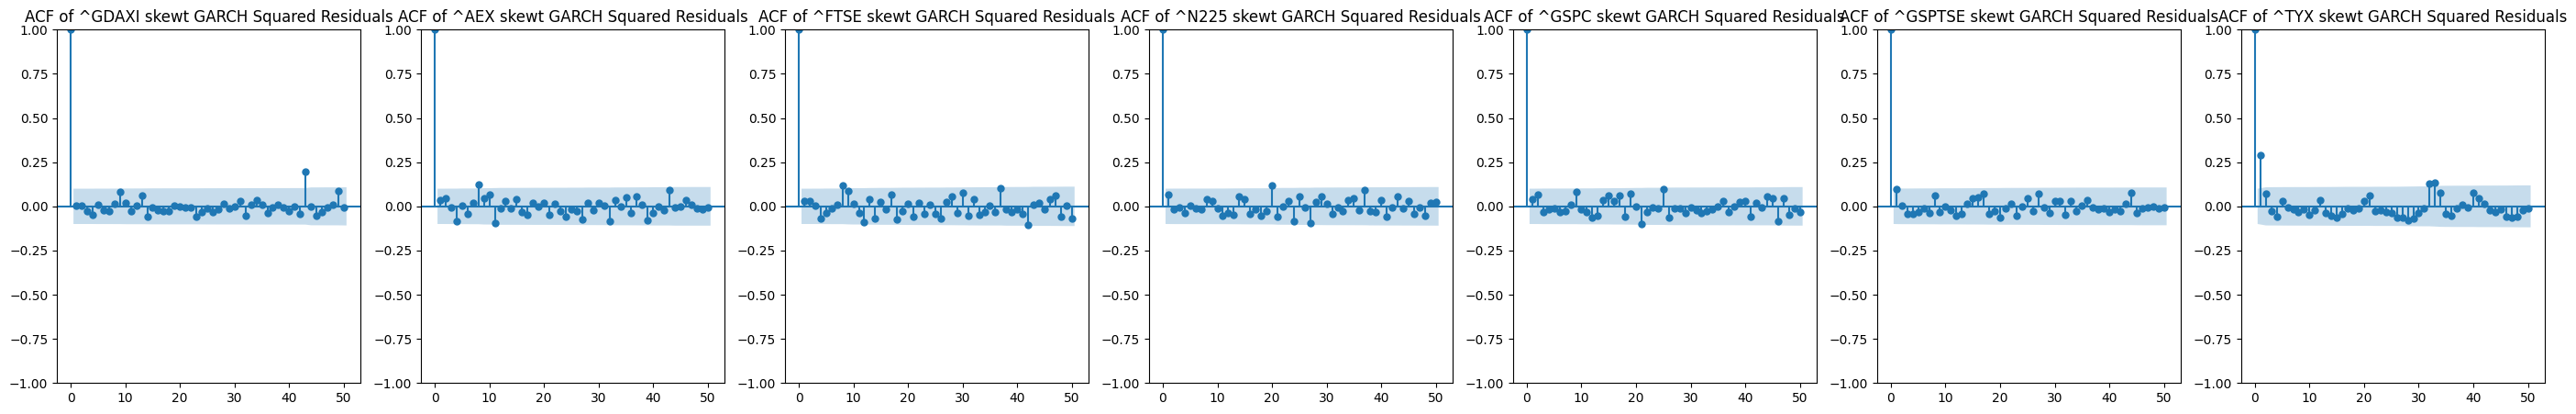

In [9]:

#This plots the ACF of the squared residuals of each GARCH, and displays them side by side for comparision
for dist in distributions:
    num_tickers = len(tickers)
    fig, axes = plt.subplots(1, num_tickers, figsize=(5 * num_tickers, 5))
    for i in range(num_tickers):
        ticker = tickers[i]
        plot_acf(std_residuals[(ticker,dist)]**2, lags=50, ax=axes[i]) 
        axes[i].set_title('ACF of ' + ticker + " " + dist + ' GARCH Squared Residuals')



The above results suggest that there is little autocorrelation in the stardarized squared residuals of our fitted GARCH models.

##### Plot QQ Plot for residuals

QQ Plots of normal GARCH Residuals


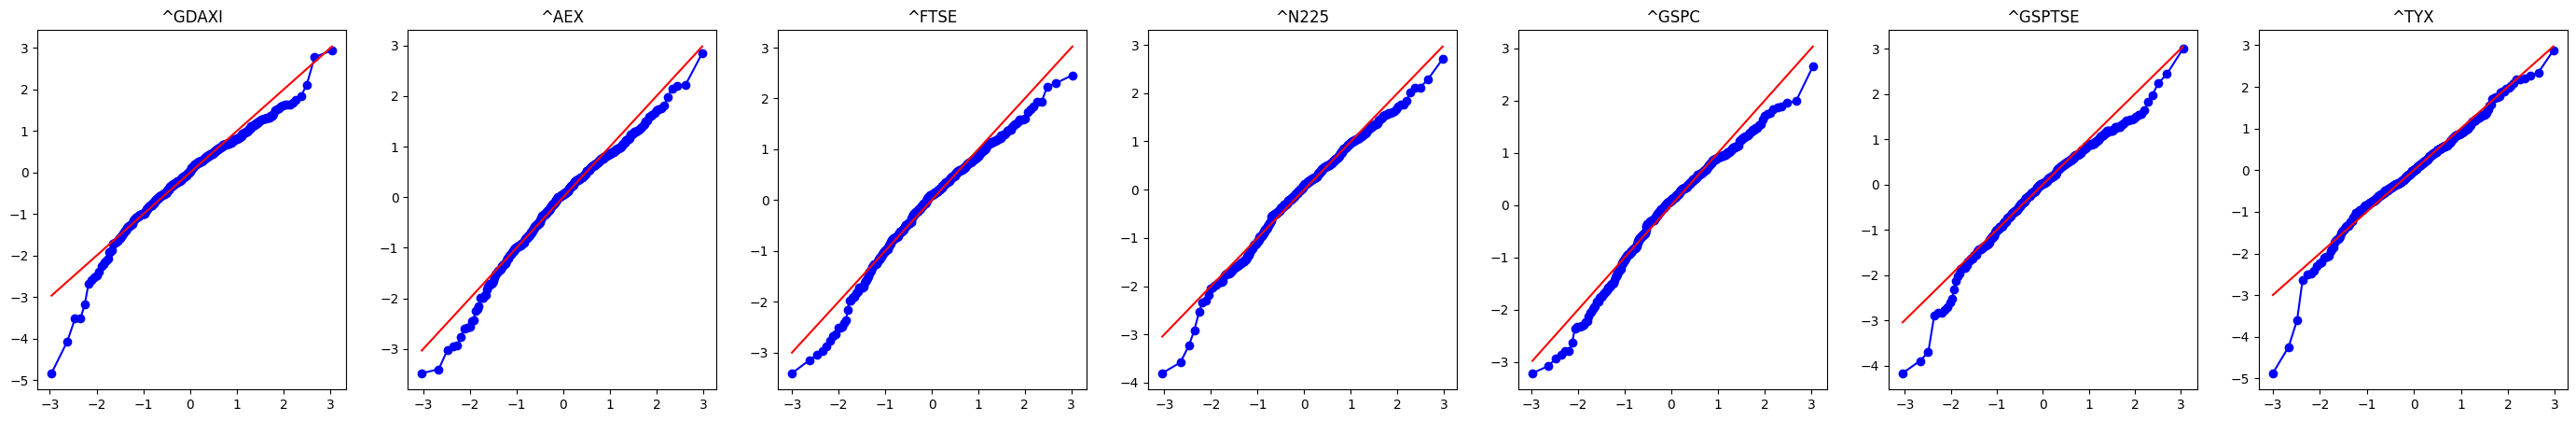

QQ Plots of t GARCH Residuals


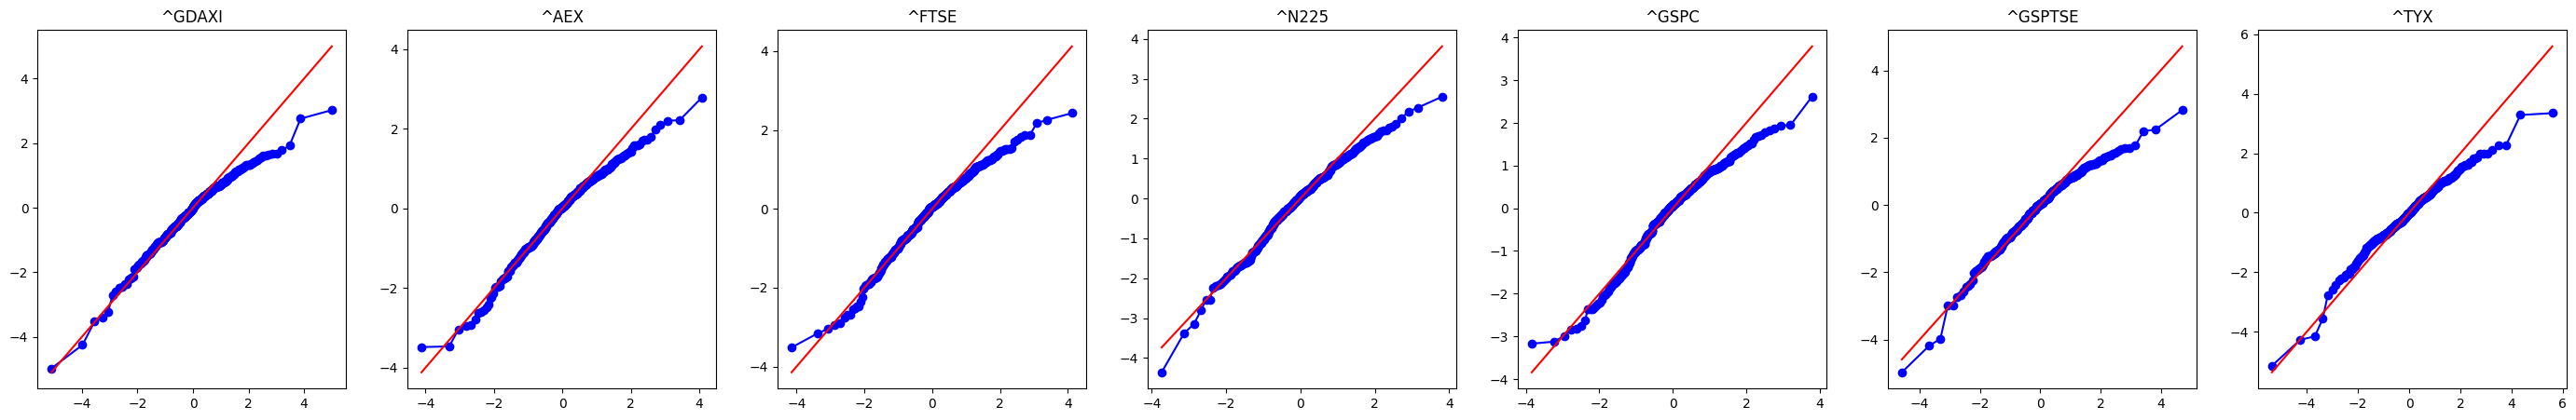

QQ Plots of skewt GARCH Residuals


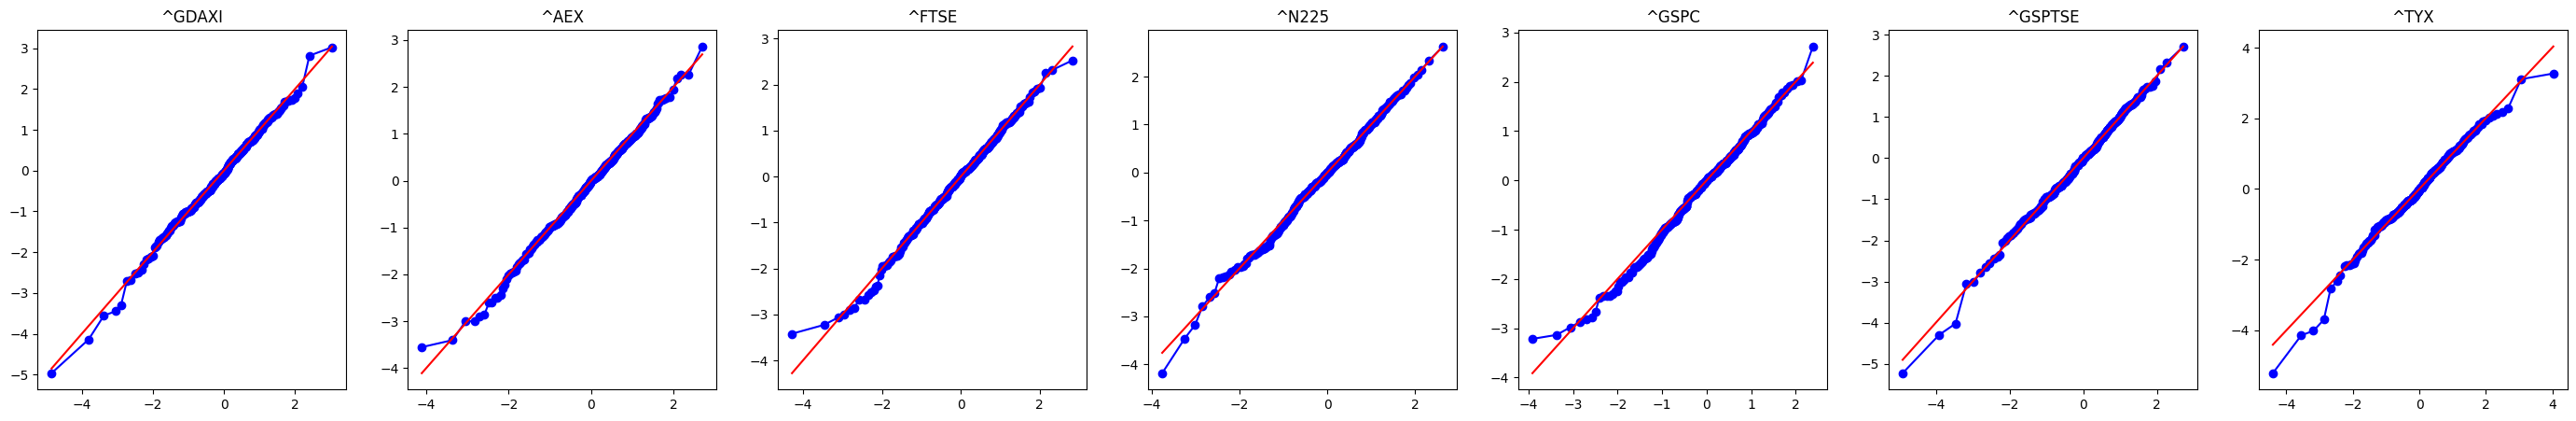

In [10]:

#This plots the ACF of the squared residuals of each GARCH, and displays them side by side for comparision
for dist in distributions:
    print('QQ Plots of ' + dist + ' GARCH Residuals')
    num_tickers = len(tickers)
    fig, axes = plt.subplots(1, num_tickers, figsize=(5 * num_tickers, 5))

    n = len(merged_data)
    
    quantiles = (np.arange(1, n + 1) - 0.5) / n

    for i in range(num_tickers):
        
        ticker = tickers[i]

        if dist == 'normal': theoretical_quantiles  =  np.quantile(norm.rvs(0,1,100000), quantiles)

        elif dist == 't':
            nu =  fitted_models[(ticker,dist)].params["nu"]
            theoretical_quantiles  =  np.quantile(t.rvs(nu,0,1,100000), quantiles)

        elif dist == 'skewt': 
            eta = fitted_models[(ticker,dist)].params["eta"]
            lambda_param = fitted_models[(ticker,dist)].params["lambda"]
            skew_t_rvs = SkewStudent().simulate(parameters=[eta, lambda_param])
            theoretical_quantiles  =  np.quantile(skew_t_rvs(10000), quantiles)

        sorted_std_residuals = sorted(std_residuals[(ticker,dist)])
     
        axes[i].plot(theoretical_quantiles,sorted_std_residuals,color = "blue", marker = 'o')
        axes[i].plot(theoretical_quantiles,theoretical_quantiles,color = "red")
        axes[i].set_title(ticker)

    plt.show()
        




The above results suggest that the skewed Student's-t distribution has the best fit, across all indices.



However, most of the our models predict slightly more extreme negtaive shocks than the data suggests, as evident by bottom left regions in the above QQ Plots.

## Fit Multivariate Model

# Compute Spearman's Variance-Covariance Matrix
Using the standarized residuals from our Student's t GARCH model, we calculate the spearman correlation & covariance of the standarized residuals.

In [11]:
tickers = ["^GDAXI", "^AEX", "^FTSE", "^N225", "^GSPC", "^GSPTSE"] #We will only refer to our equity indices henceforth
spearman_cov = {}

print("Spearman Correlation Matrix of Standarized Residuals")
for dist in distributions:
    temp = pd.DataFrame(index=tickers,columns=tickers)
    for ticker_1 in tickers:
        for ticker_2 in tickers:
            
            #Rank residuals
            ranked_residuals_1 = pd.Series(std_residuals[(ticker_1,dist)]).rank(method='average')
            ranked_residuals_2 = pd.Series(std_residuals[(ticker_2,dist)]).rank(method='average') 
            
            #Compute Spearman Correlation Coeff./Covariance 
            temp.loc[ticker_1,ticker_2] = np.corrcoef(ranked_residuals_1,ranked_residuals_2)[0][1]
            
    spearman_cov[dist] = temp        
    print("GARCH Distribution: ",dist)
    print(spearman_cov[dist])
    spearman_cov[dist] = spearman_cov[dist].to_numpy(dtype=float) #convert to numpy array for later
    print()


Spearman Correlation Matrix of Standarized Residuals
GARCH Distribution:  normal
           ^GDAXI      ^AEX     ^FTSE     ^N225     ^GSPC   ^GSPTSE
^GDAXI        1.0  0.834389  0.722828  0.528443  0.715045  0.640025
^AEX     0.834389       1.0  0.748364   0.52752  0.715801  0.643565
^FTSE    0.722828  0.748364       1.0  0.414478  0.684442  0.674762
^N225    0.528443   0.52752  0.414478       1.0  0.511986  0.436771
^GSPC    0.715045  0.715801  0.684442  0.511986       1.0  0.730446
^GSPTSE  0.640025  0.643565  0.674762  0.436771  0.730446       1.0

GARCH Distribution:  t
           ^GDAXI      ^AEX     ^FTSE     ^N225     ^GSPC   ^GSPTSE
^GDAXI        1.0  0.834805   0.72218  0.531475  0.713148  0.639529
^AEX     0.834805       1.0  0.747889  0.531233  0.714845  0.648134
^FTSE     0.72218  0.747889       1.0  0.415437  0.682222   0.67857
^N225    0.531475  0.531233  0.415437       1.0  0.514955  0.443044
^GSPC    0.713148  0.714845  0.682222  0.514955       1.0  0.733162
^GSPTSE  0.

#### Fit Student's-t Copula
Next, we will fit our Student's-t copula to our normal, Student's-t and skewed Student's-t GARCH marginal residuals. To do this, we will use the Spearman correlation matrices $\Sigma_{COR}$ from above. We can numerically estimate our fitted degrees of freedom $\nu$, with the constraint that $\nu > 2$, by using scipy's minimize function, applied to our copula's log likelihood function. 

In [12]:
merged_residuals,u,fitted_df,mu,omega,x = {},{},{},{},{},{}


def negative_tcopula_log_likelihood(nu,corr,x):
    copula = StudentTCopula(corr=corr,df = nu, k_dim=corr.shape[0])

    return -1*sum(copula.logpdf(row) for row in x.T)


options = {
    'maxiter': 10000, #Max iterations
    'gtol': 1e-12, #Tolerance for convergence
    'disp': True #Display warnings
}

for dist in distributions:
    merged_residuals[dist] = np.array([std_residuals[(ticker, dist)] for ticker in tickers])
    t_model = t.fit(merged_residuals[dist])
    u[dist] = t.cdf(merged_residuals[dist],t_model[0],t_model[1],t_model[2])

    fitted_df[dist] = minimize(negative_tcopula_log_likelihood,10, args = (spearman_cov[dist],u[dist]),bounds = [(2,1000)],options = options).x

print("Multivariate-t fitted degrees of freedom for standaridized residuals:")
print("Normal:",fitted_df["normal"])
print("Student's-t:",fitted_df["t"])
print("Skewed Student's-t:",fitted_df["skewt"])


Multivariate-t fitted degrees of freedom for standaridized residuals:
Normal: [11.33194331]
Student's-t: [11.03030989]
Skewed Student's-t: [11.03619766]


Following the procedure in "Copula Methods in Finance", we can sample from our Student's t-copula using the following algorithm:

1. Find the Choelsky Decomposition A of R, where R represents our Spearman Correlation Matrix
2. Simulate $n$ i.i.d. $N(0,1)$ random variables $z_i$, set $z=(z_1,z_2,...,z_n)$
3. Set $X = Az$
4. Simulate $s\sim\chi^2_\nu$ independently of $z$
5. Set $x = \sqrt{\frac{\nu}{s}}y$
6. Set $u_i = F_\nu (x_i)$ for $i=1,2,...,n$ where $F_nu$ represents the univariate Student's t c.d.f. with $\nu$ degrees of freedom 


We can then set $t_i = F^{-1}_i (u_i)$ for $i=1,2,...,n$ where $F_i^{-1}$ represents the marginal inverse c.d.f for $t_i$


Here, each $t_i$ represents a simulated standardized residual.

Conveniently, the statsmodels StudentTCopula class allows us to sample from our copula directly. We will use this instead to conduct 100,000 samples from our copula. Then, applying the marginal inverse c.d.f's component wise, we get 100,000 simulations for our standardized residuals.

In [45]:
num_samples = 100000

copulas = {dist: StudentTCopula(corr=spearman_cov[dist],
                                df = fitted_df[dist], 
                                k_dim=spearman_cov[dist].shape[0]) for dist in distributions}

simulated_u = {dist: copulas[dist].rvs(num_samples) for dist in distributions}

def inverse_marginal(x,dist):
    marginals = []
    for ticker in tickers:
        mu = fitted_models[(ticker,dist)].params["mu"]
        omega = fitted_models[(ticker,dist)].params["omega"]
    
        if dist == "normal" :
            marginals.append(norm.ppf(x[:,tickers.index(ticker)],loc=mu/100,scale = np.sqrt(omega)/100))
        elif dist == "t":
            nu = fitted_models[(ticker,dist)].params["nu"]
            marginals.append(t.ppf(x[:,tickers.index(ticker)],df = nu, loc=mu/100,scale = np.sqrt(omega)/100))
        elif dist == "skewt":
            eta = fitted_models[(ticker,dist)].params["eta"]
            lambda_param = fitted_models[(ticker,dist)].params["lambda"]
            marginals.append((SkewStudent().ppf(pits = x[:,tickers.index(ticker)],parameters=[eta,lambda_param]) )*np.sqrt(omega)/100 + mu/100)
    return np.array(marginals)

simulated_t = {dist: inverse_marginal(simulated_u[dist],dist) for dist in distributions}

QQ Plots of copula marginal simulated returns vs marginal returns - normal GARCH Residuals


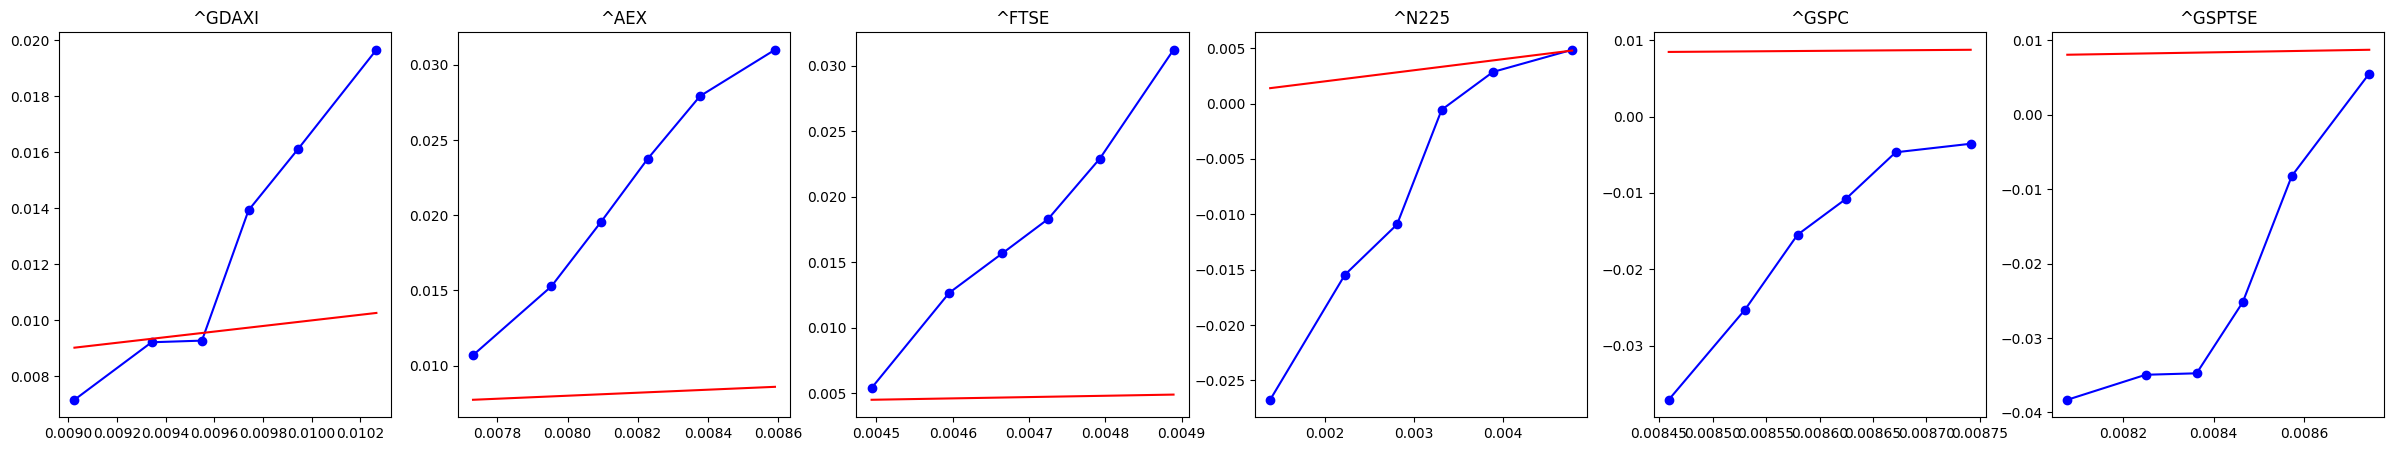

QQ Plots of copula marginal simulated returns vs marginal returns - t GARCH Residuals


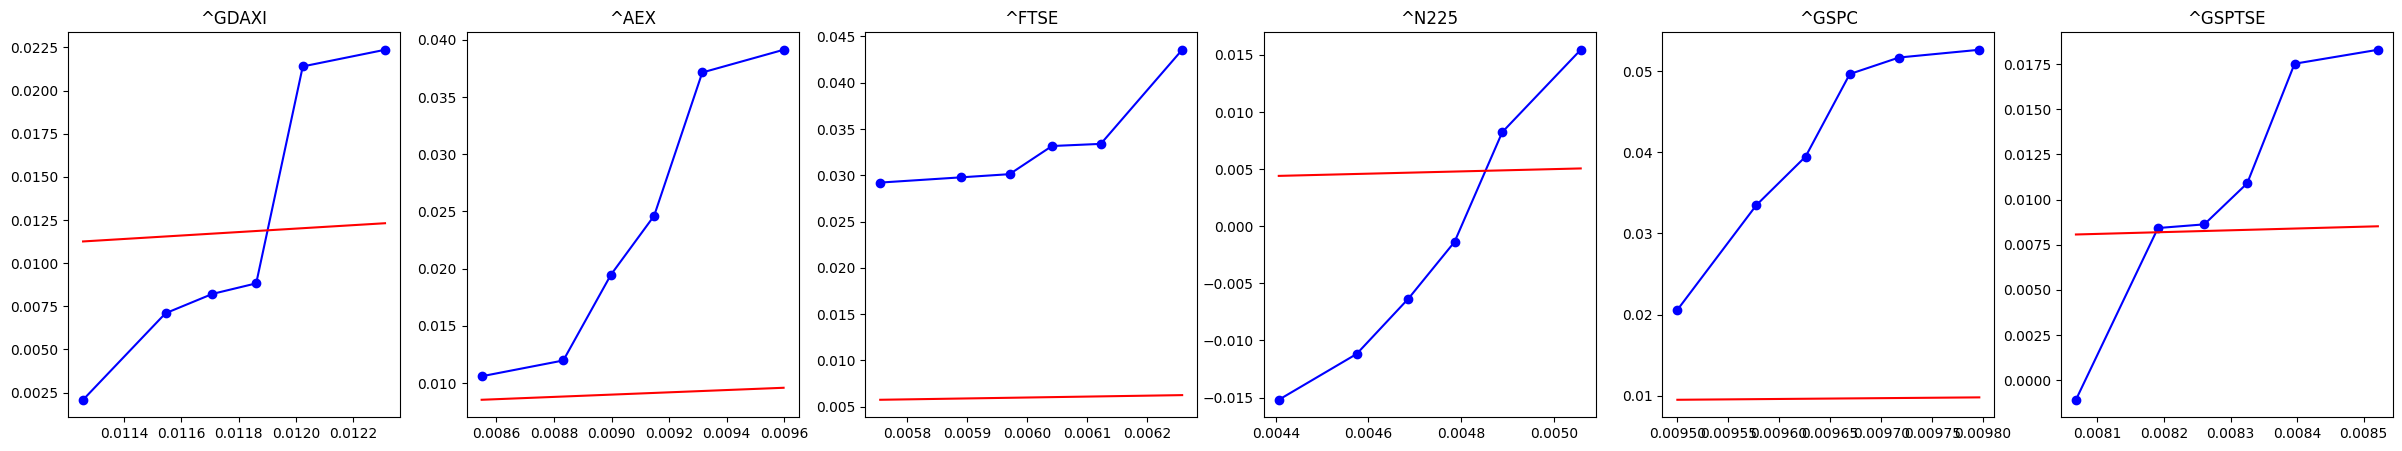

QQ Plots of copula marginal simulated returns vs marginal returns - skewt GARCH Residuals


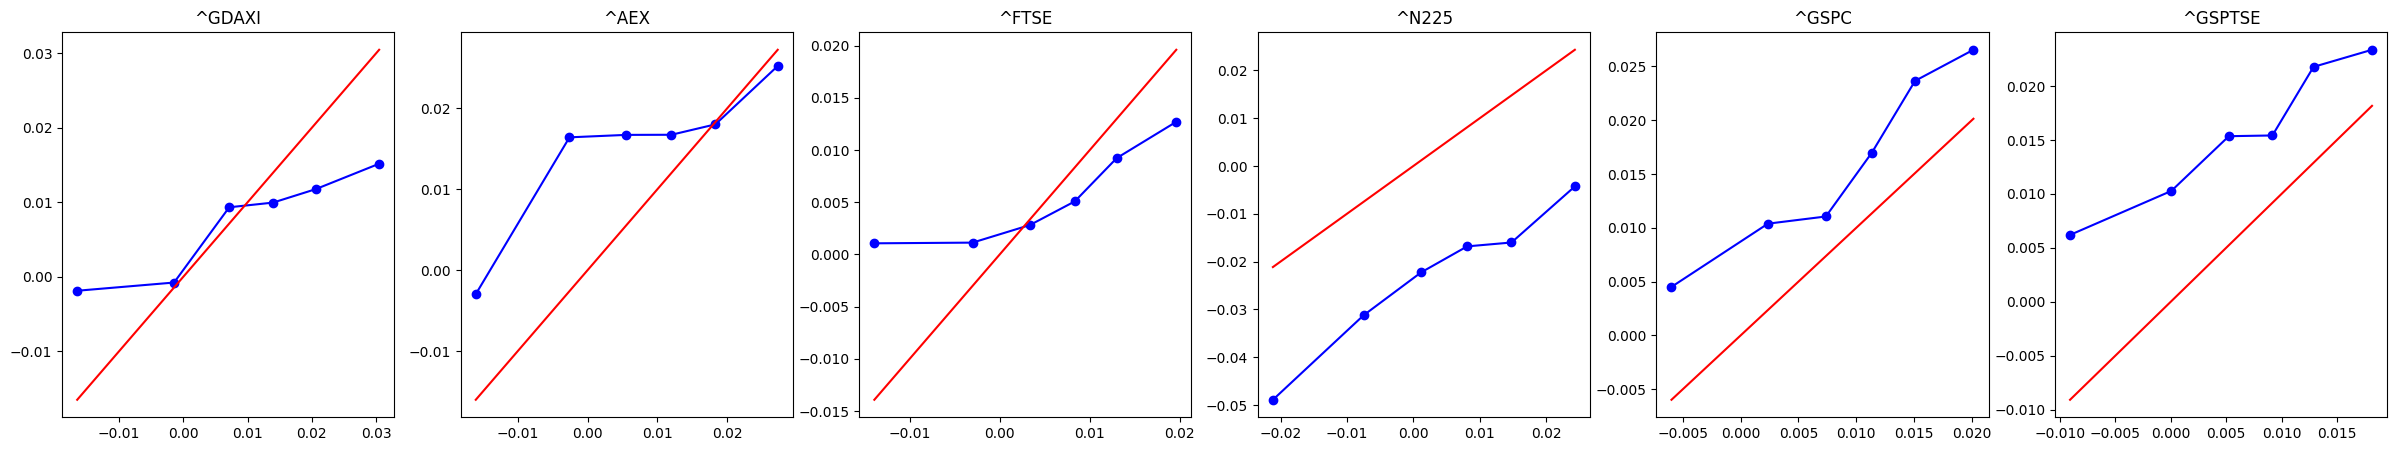

In [46]:


for dist in distributions:
    fig, axes = plt.subplots(1, num_tickers, figsize=(5 * num_tickers, 5))
    print('QQ Plots of copula marginal simulated returns vs marginal returns - ' + dist + ' GARCH Residuals')
    num_tickers = len(tickers)
    

    n = len(simulated_t[dist])

    quantiles = (np.arange(1, n + 1) - 0.5) / n
    
    for i in range(num_tickers):
        
        ticker = tickers[i]
        theoretical_quantiles = []
        mu = fitted_models[(ticker,dist)].params["mu"]/100
        omega = fitted_models[(ticker,dist)].params["omega"]/10000

        if dist == 'normal': theoretical_quantiles  =  np.quantile(norm.rvs(mu,omega,10000), quantiles)

        elif dist == 't':
            nu =  fitted_models[(ticker,dist)].params["nu"]
            theoretical_quantiles  =  np.quantile(t.rvs(nu,mu,omega,10000), quantiles)

        elif dist == 'skewt': 
            eta = fitted_models[(ticker,dist)].params["eta"]
            lambda_param = fitted_models[(ticker,dist)].params["lambda"]
            skew_t_rvs = SkewStudent().simulate(parameters=[eta, lambda_param])
            theoretical_quantiles  =  np.quantile(skew_t_rvs(10000)*np.sqrt(omega) + mu, quantiles)
        
        simulated_results_sorted = sorted(simulated_t[dist].T[i])

        axes[i].plot(theoretical_quantiles,simulated_results_sorted,color = "blue", marker = 'o')
        axes[i].plot(theoretical_quantiles,theoretical_quantiles,color = "red")
        axes[i].set_title(ticker)

    plt.show()

 

# Maha stuffWe will conduct a goodness of fit test using the squared Mahalanobis distance.

Note that if $$t=\begin{pmatrix}
t_1 \\
t_2 \\
t_3 \\
\vdots \\
t_d
\end{pmatrix}
\sim t_{\nu} (\mu,\Sigma)$$
Then we can write $$t = \mu + \sqrt{\frac{\nu}{W}} X$$ Where $X\sim N_d(0,\Sigma), W \sim \chi^2_\nu,$ and $W$ & $Z$ are independent.
Recall that the squared Mahalanobis distance for a variable t is given by:
$$D^2 = (t-\mu)^\top \Sigma^{-1}(t-\mu)$$

Substituting $t = \mu + \sqrt{\frac{\nu}{W}} Z$ for $X$, we get
$$D^2 = \left(\sqrt{\frac{\nu}{W}}Z\right)^\top \Sigma^{-1}\left(\sqrt{\frac{\nu}{W}}Z\right)= \frac{\nu}{W} Z^\top \Sigma^{-1} Z$$

Now, since $Z\sim N_d(0,\Sigma)$, we have that $$Z^\top \Sigma^{-1} Z\sim \chi^2_d$$
We can let $U= Z^\top \Sigma^{-1} Z\sim \chi^2_d$ so that 
$$D^2 = \frac{\nu}{W}U = p\frac{(U/p)}{(W/\nu)}$$

Then,
$$\frac{D^2}{p} =\frac{(U/p)}{(W/\nu)} \sim F(p,\nu)$$


The above QQ Plots show that our Multivariate T distribution closely fits the standaridized residuals, especically when our residuals come from the Student's-t, and skewed Student's-t GARCH models.

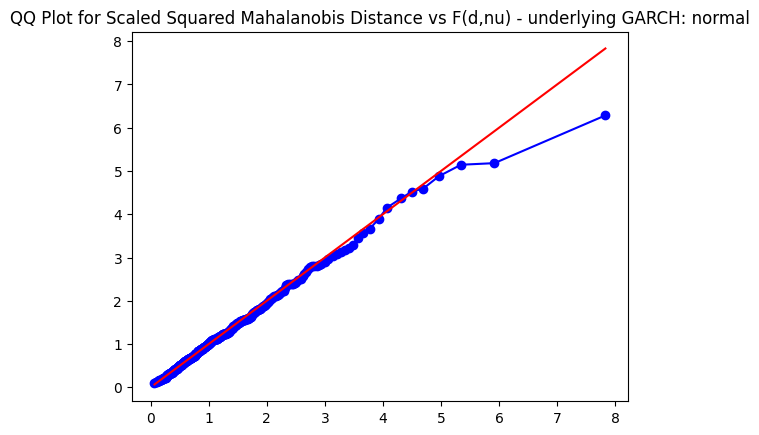

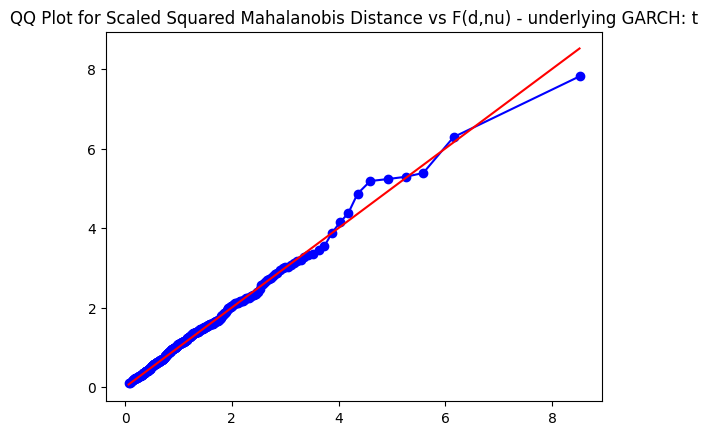

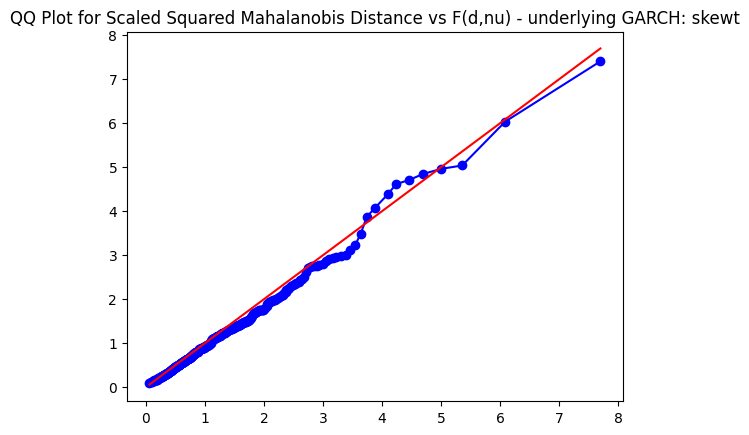

In [18]:
def Squared_Mahalanobis_distance(x, sigma_inv,mu):
    return np.dot((x-mu),np.dot(sigma_inv,(x-mu)))

print()
for dist in distributions:

    f_samples = f.rvs(len(tickers),fitted_df[dist],size = 10000)
    scale_inv = np.linalg.inv(spearman_cov[dist])

    mu = [fitted_models[(ticker,dist)].params["mu"] for ticker in tickers]
    D_squared_over_p = [Squared_Mahalanobis_distance(row,scale_inv,mu)/ len(tickers) for row in merged_residuals[dist].T] 
    
    n = len(D_squared_over_p)
    quantiles = (np.arange(1, n + 1) - 0.5) / n

    
    theoretical_quantiles  =  np.quantile(f_samples, quantiles)
    sample_quantiles = np.quantile(sorted(D_squared_over_p),quantiles)
     
    plt.plot(theoretical_quantiles,sample_quantiles,color = "blue", marker = 'o')
    plt.plot(theoretical_quantiles,theoretical_quantiles,color = "red")
    plt.title("QQ Plot for Scaled Squared Mahalanobis Distance vs F(d,nu) - underlying GARCH: "+dist)
    plt.show()

We can forecast the one period ahead return as follows:

1. Forecast the conditional volatility of each index using our GARCH models
2. Multiply each simulated standardized residual by our conditional volatility forecasts - this gives a raw residual forecast for each index
3. Add our mean log-return to each residual forecast - this yields a one-period ahead forecast for each index, following our dependence structure





In [16]:
forecast_dfs = {}


def compute_forecast(dist,cond_vol_index = -1):
    forecasts = {}
    for ticker in tickers:
        forecasts[ticker] = mu[(ticker,dist)]/100 + simulated_t[(ticker,dist)]*fitted_models[(ticker,dist)].conditional_volatility.iloc[cond_vol_index]
    
    return pd.DataFrame(forecasts)


strikes = [0.01,0.02,0.03,0.04,0.05]


for dist in distributions:
    print("GARCH Model:",dist)
    
    forecasts = compute_forecast(dist, )
    for ticker in tickers:
        forecasts[ticker] = mu[(ticker,dist)]/100 + simulated_t[(ticker,dist)]*fitted_models[(ticker,dist)].conditional_volatility.iloc[-1]
    
    #convert to simple returns for computing payoff
    forecast_dfs[dist] = np.exp(pd.DataFrame(forecasts)) - 1

    strikes = [0.01,0.02,0.03,0.04,0.05]
    forecast_dfs[dist]["Average"] = forecast_dfs[dist].mean(axis=1)
    for k in strikes:
        forecast_dfs[dist]["Basket Payoff, strike:",k] = np.maximum(forecast_dfs[dist]["Average"] - k,0)

    for k in strikes:
        print("Strike:",k,"Payoff:",forecast_dfs[dist]["Basket Payoff, strike:",k].mean())
        
    plt.hist(forecast_dfs[dist]["Average"], density = True, bins = 20)
    plt.title(dist+" GARCH - Simulated Density of Simple Returns")
    plt.show()
    print()

GARCH Model: normal


TypeError: list indices must be integers or slices, not tuple

#### Historical Payoffs

Here we compute the historical payoff of our basket option, for various strikes, at each month in our dataset.

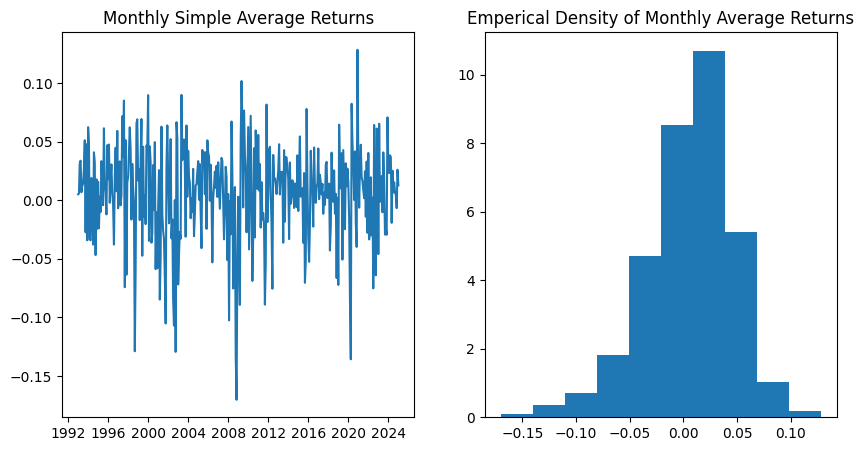

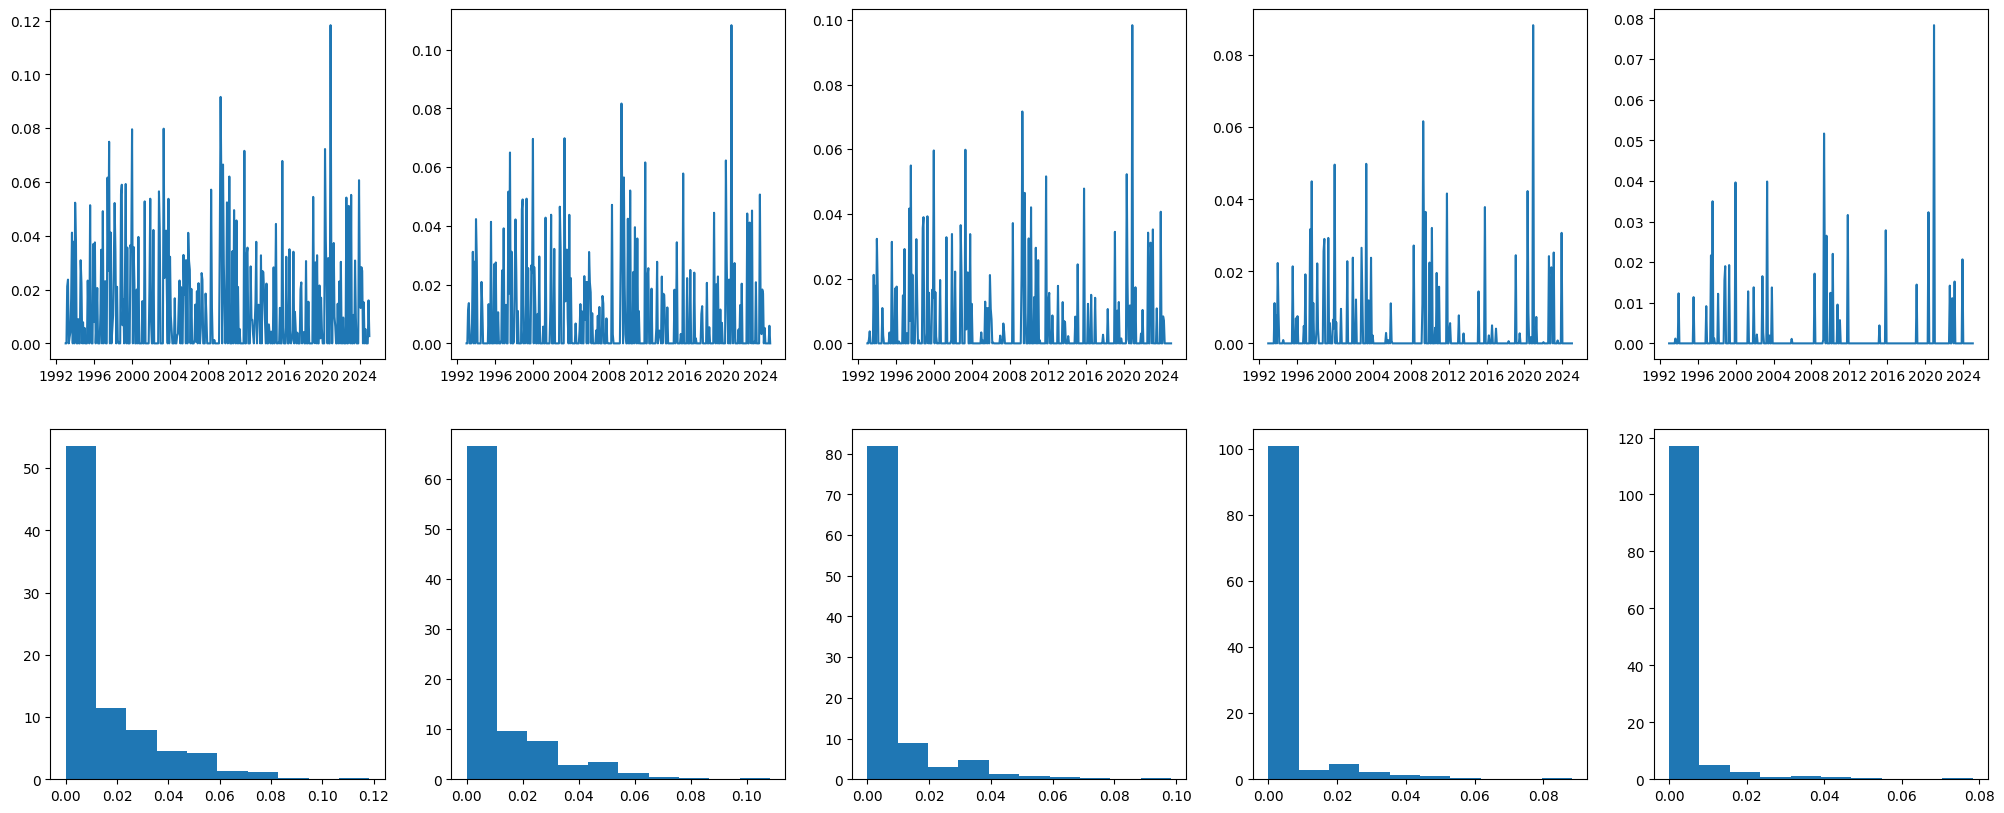

In [188]:
merged_data["Simple Average Return"] = np.exp(merged_data[tickers]).mean(axis=1) - 1

fig, axes = plt.subplots(1, 2, figsize=(5 * 2, 5))

axes[0].plot(merged_data["Simple Average Return"])
axes[0].set_title("Monthly Simple Average Returns")
axes[1].hist(merged_data["Simple Average Return"], density  = True)
axes[1].set_title("Emperical Density of Monthly Average Returns")
plt.show()

fig, axes = plt.subplots(2, len(strikes), figsize=(5* len(strikes), 10 ))

for i in range(len(strikes)):
    k = strikes[i]
    axes[0][i].plot(np.maximum(merged_data["Simple Average Return"] - k, 0))
    axes[1][i].hist(np.maximum(merged_data["Simple Average Return"] - k, 0), density = True)

##### Conduct Historical Simulation

Next, we compute the conditional volatility of our log returns. We then compute 10000 simulations at each month, to estimate the basket option payoff at time t. We repeat this process assuming different conditional volatility distributions. We then compare our estimates to the historical payoffs.

In [ ]:
historical_price = {}
for dist in distributions:
    
    for i in len(merged_data["Simple Average Return"]):
        historical_price[i] = compute_forecast(dist,i)
        


    



### References
1. https://users.ssc.wisc.edu/~bhansen/papers/ier_94.pdf skewed students t

https://onlinelibrary-wiley-com.libproxy.wlu.ca/doi/pdf/10.1002/9781118673331 reference

ifm https://open.library.ubc.ca/media/stream/pdf/52383/1.0225985/5

arch https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.SkewStudent.html

1. Author, *Title of the Book/Article*, Publisher, Year.
